In [1]:
# Handwritten Neural Network test: HandwrittenNN.ipynb
# Author: comtalyst

'''
TODO:
- continue on fundamentals structure (probably start with initialize variables)
- test backprop by gradient checking 
- test cost function by running grad
- generate test data if possible
'''

'\nTODO:\n- continue on fundamentals structure (probably start with initialize variables)\n- test backprop by gradient checking \n- test cost function by running grad\n- generate test data if possible\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Activation functions

## Sigmoid
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

def sigmoid_deriv(Z):
    '''
    (Coursera DL Notes, p. 8)
    '''
    A = sigmoid(Z)
    return A*(1 - A)

## ReLu
def relu(Z):
    A = np.maximum(0, Z)
    return A

def relu_deriv(Z):
    '''
    (Coursera DL Notes, p. 9)
    '''
    A = np.ones(Z.shape)
    A[Z <= 0] = 0
    #print("Relu(" + str(Z) + ") = " + str(A))
    return A

## Global interface
def activate(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid(Z)
    elif activation == "relu":
        return relu(Z)
    else:
        return Z

def activate_deriv(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid_deriv(Z)
    elif activation == "relu":
        return relu_deriv(Z)
    else:
        return 1

In [4]:
### Cost functions

# These are untested, will be tested when running descent
def compute_loss(Y_, Y):
    '''
    (Coursera DL Notes, p. 4)
    (C1W4 , Block 5)
    '''
    loss = -(np.dot(Y, np.log(Y_).T) + np.dot(1-Y, np.log(1-Y_).T) )
    return loss

def compute_cost(Y_, Y):
    '''
    (C1W4, dnn_app_utils_v3.py)
    '''
    m = Y.shape[1]
    cost = (1/m) * compute_loss(Y_, Y)
    cost = np.squeeze(cost)
    return cost

In [5]:
### Initialization

def initialize_parameters(layers):
    L = len(layers)-1

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)
    for l in range(1, L+1):
        W[l] = np.random.randn(layers[l], layers[l-1])*0.1
        b[l] = np.zeros((layers[l], 1))

    return W, b

In [6]:
### Forward propagation

# X: input in [features x samples]
# W: learnable parameters in [layer x n(l) x n(l-1)]
# b: bias parameters in [layer x n(l) x 1]
# activations: an arraylist of string, size of l, denotes preferred activation for each layer
#   example: {relu, relu, sidmoid} means relu in l = 1,2, sigmoid in l = 3
def forward_propagation(X, W, b, activations):
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    # initialize linear output
    '''
    This np.ndarray allow us to contruct an array with size initialized and can have any data type in it (from dtype=object)
    Therefore, we could use this to create histogram-like array for the uneven NN
    '''
    Z = np.ndarray(shape=[L+1], dtype=object)
    A = np.ndarray(shape=[L+1], dtype=object)
    
    # base case
    A[0] = X

    # loop the layers 1 to L
    for l in range(1, L+1):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        A[l] = activate(Z[l], activations[l-1])     # note that activations[]'s index is behind for the ease of user

    return A, Z
        

In [7]:
### Backward Propagation

def backward_propagation(X, Z, A, W, b, Y, activations):
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    dZ = np.ndarray(shape=Z.shape, dtype=object)
    dA = np.ndarray(shape=A.shape, dtype=object)
    dW = np.ndarray(shape=W.shape, dtype=object)
    db = np.ndarray(shape=b.shape, dtype=object)
    '''
    (Coursera DL Notes, p. 10)
    '''
    A[0] = X                # to make it work properly when l = 1 
    # base case
    dA[L] = -(np.divide(Y, A[L]) - np.divide(1-Y, 1-A[L]))
    '''
    Actually, either ways give the same answer for logistic regression (currently wrong both)
    Also, both dW and dB is wrong in a similar (not exact same) scale
    The true bug should come from dZ since db = dZ when simple LR
    Therefore, based on grad approx, A[L] - Y should be super small???? That's actually uncontrollable
    dZ[L] = A[L] - Y
    dW[L] = (1/m)*np.dot(dZ[L], A[L-1].T)
    db[L] = (1/m)*np.sum(dZ[L], axis = 1, keepdims = True) 
    '''

    # loop the layers L to 1
    for l in reversed(range(1, L+1)):
        dZ[l] = dA[l] * activate_deriv(Z[l], activations[l-1]) 
        dW[l] = (1/m)*np.dot(dZ[l], A[l-1].T)
        db[l] = (1/m)*np.sum(dZ[l], axis = 1, keepdims = True) 
        #print(db[l])
        #print(dZ[l])
        dA[l-1] = np.dot(W[l].T, dZ[l])
    
    return dW, db


In [8]:
### Update paremeters

def update_parameters(W, b, dW, db, learning_rate):
    L = len(W)-1
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    return W, b

In [9]:
### Train model

def train_model(X, Y, layers, activations, learning_rate, iterations):
    W, b = initialize_parameters(layers)
    for i in range(0, iterations):
        A, Z = forward_propagation(X, W, b, activations)
        #print(A[len(A)-1])
        if iterations < 100 or i%(iterations//100) == 0:
            print("Iteration " + str(i) + ": cost = " + str(compute_cost(A[len(A)-1], Y)))
        dW, db = backward_propagation(X, Z, A, W, b, Y, activations)
        W, b = update_parameters(W, b, dW, db, learning_rate)
    return W, b, dW, db

In [10]:
##########      BELOW THIS LINE IS PERFORMANCE AREA      ##########

In [11]:
### Process raw data
## read file
path = "data/"
filename = "2d_2color_dots.txt"
f = open(path + filename, "r")

## generate a long, combined string from the file
fstr = f.read()
fstr = fstr.replace('\n', ' ')
fstr = fstr.strip()

## process file
flist = fstr.split(' ')
fnparray = np.array(flist)
m = len(flist)//3

## ready to put to our inputs
X = np.ndarray([2, m])
Y = np.ndarray([1, m])              
X[0] = fnparray[0:m].astype(float)
X[1] = fnparray[m:2*m].astype(float)
Y[0] = fnparray[2*m:].astype(int)               # use [0] to prevent array conversion error

'''
NO NEED BECAUSE NOT MULTICLASS CLASSIFICATION
## convert Y to 0-1 2d array
# in this case, we have two possible outcomes (true-false)
Y = np.ndarray([2, m])
Y[0] = (Y_r == 0)
Y[1] = (Y_r == 1)
'''

'\nNO NEED BECAUSE NOT MULTICLASS CLASSIFICATION\n## convert Y to 0-1 2d array\n# in this case, we have two possible outcomes (true-false)\nY = np.ndarray([2, m])\nY[0] = (Y_r == 0)\nY[1] = (Y_r == 1)\n'

In [12]:
### Create and train a model from provided data

## create a model
np.random.seed(197)
layers = [2, 4, 4, 4, 1]                                 # first and last is defined by input type (2D coords, true-false)
activations = ['relu', 'relu', 'relu', 'sigmoid']
learning_rate = 0.04
iterations = 10000

## train it
W, b, dW, db = train_model(X, Y, layers, activations, learning_rate, iterations)

## pack for easier future use
model = [W, b, activations]
grads = [dW, db]

Iteration 0: cost = 0.7012374082086391
Iteration 100: cost = 0.6814684260915742
Iteration 200: cost = 0.5922092333729234
Iteration 300: cost = 0.5486692473453223
Iteration 400: cost = 0.5192782629662744
Iteration 500: cost = 0.49995365120831603
Iteration 600: cost = 0.4873398778242945
Iteration 700: cost = 0.47920849999235143
Iteration 800: cost = 0.47394863167973356
Iteration 900: cost = 0.47064611259542005
Iteration 1000: cost = 0.4685997045515791
Iteration 1100: cost = 0.4566238151468622
Iteration 1200: cost = 0.3239979987054595
Iteration 1300: cost = 0.34455868216071317
Iteration 1400: cost = 0.3837859689466736
Iteration 1500: cost = 0.37835164034652813
Iteration 1600: cost = 0.37080800347398346
Iteration 1700: cost = 0.36395765615515824
Iteration 1800: cost = 0.35596148920027343
Iteration 1900: cost = 0.3505578370881665
Iteration 2000: cost = 0.34420688683494616
Iteration 2100: cost = 0.3399700249541896
Iteration 2200: cost = 0.33558692005201973
Iteration 2300: cost = 0.3328031680

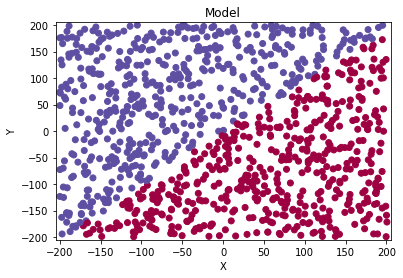

In [13]:
### Model analysis
def predict_dec(X, model):
    # return predictions of X based on provided model
    """
    Original version author: Andrew Ng
    """
    threshold = 0.4
    W, b, activations = model
    L = len(activations)

    A, Z = forward_propagation(X, W, b, activations)
    predictions = (A[L] > threshold)
    return predictions

def plot_decision_dots(X, Y, Y_):
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.scatter(X[0, :], X[1, :], c=Y_.astype(int), cmap=plt.cm.Spectral)
    plt.show()

# Plot predictions w/ color (not including boundary)
plt.title("Model")
axes = plt.gca()
axes.set_xlim([-205, 205])
axes.set_ylim([-205, 205]) 
plot_decision_dots(X, Y, predict_dec(X, model))

In [14]:
### Gradient Checking (Mostly Andrew Ng's code)

# convert to one long vector
def rollout(W, b):
    L = len(W)-1
    rolled = np.reshape(W[1], (-1, 1))                  # flatten this 2D W[][]
    rolled = np.concatenate((rolled, b[1]),axis=0)
    for i in range(2, L+1):
        rolled = np.concatenate((rolled, np.reshape(W[i], (-1, 1)) ),axis=0)
        rolled = np.concatenate((rolled, b[i]),axis=0)
    return rolled

# convert one long vector back to original
def reroll(theta, origW, origb):
    W = np.copy(origW)
    b = np.copy(origb)
    L = len(W)-1
    idx = 0
    for i in range(1, L+1):
        sz = origW[i].shape[0] * origW[i].shape[1]
        W[i] = theta[idx:idx+sz].reshape(origW[i].shape)
        idx += sz

        sz = origb[i].shape[0] * origb[i].shape[1]
        b[i] = theta[idx:idx+sz].reshape(origb[i].shape)
        idx += sz
    return W, b

def gradient_check_n(model, grads, X, Y, epsilon = 1e-7):    
    # Set-up variables
    W, b, activations = model
    dW, db = grads
    L = len(activations)

    # convert to each to one long vector (see function rollout() above)
    parameters_values = rollout(W, b)
    grad = rollout(dW, db)

    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        thetaplus = np.copy(parameters_values)                # Step 1
        thetaplus[i][0] += epsilon                            # Step 2
        nW, nb = reroll(thetaplus, W, b)
        A, Z = forward_propagation(X, nW, nb, activations)
        J_plus[i] = compute_cost(A[L], Y)                     # Step 3  

        
        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        thetaminus = np.copy(parameters_values)                # Step 1
        thetaminus[i][0] -= epsilon                            # Step 2
        nW, nb = reroll(thetaminus, W, b)
        A, Z = forward_propagation(X, nW, nb, activations)
        J_minus[i] = compute_cost(A[L], Y)     
        
        # Compute gradapprox[i]  
        gradapprox[i] = (J_plus[i]-J_minus[i])/(2*epsilon)
    
    #print("Approx: " + str(gradapprox))
    #print("Actual: " + str(grad))
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)      # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)   # Step 2'
    difference = numerator/denominator                              # Step 3'

    if difference > 1e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

gradient_check_n(model, grads, X, Y)

There is a mistake in the backward propagation! difference = 0.006944200020339792


0.006944200020339792

In [ ]:



##########      BELOW THIS LINE IS EXPERIMENTAL AREA, THE CODE MAY BE MESSY      ##########




In [ ]:
dumb = np.ndarray(shape=[4, 5])
dumb = dumb.T
dumb

In [ ]:
def forward_propagation_test():
    L = 2
    n1 = 3
    n2 = 4
    n = 2
    m = 5
    activations = ["dumb", "dumb", "dumb"]

    X = np.round(np.random.rand(n, m)*10) % 10

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)

    W[1] = np.round(np.random.randn(n1, n)*10) % 10
    W[2] = np.round(np.random.randn(n2, n1)*10) % 10
    b[1] = np.round(np.random.randn(n1, 1)*10) % 10
    b[2] = np.round(np.random.randn(n2, 1)*10) % 10

    A, Z = forward_propagation(X, W, b, activations)
    print("X")
    print(X)
    print("W")
    print(W)
    print("b")
    print(b)
    print("A")
    print(A)
    return A, Z

def backward_propagation_test():
    L = 2
    n1 = 3
    n2 = 4
    n = 2
    m = 5
    activations = ["dumb", "dumb", "dumb"]

    X = np.round(np.random.randn(n, m)*10) % 10
    Y = np.round(np.random.randn(n2, m)*10) % 10

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)

    W[1] = np.round(np.random.randn(n1, n)*10) % 10
    W[2] = np.round(np.random.randn(n2, n1)*10) % 10
    b[1] = np.round(np.random.randn(n1, 1)*10) % 10
    b[2] = np.round(np.random.randn(n2, 1)*10) % 10

    A, Z = forward_propagation(X, W, b, activations)
    print("X")
    print(X)
    print("W")
    print(W)
    print("b")
    print(b)
    print("A")
    print(A)
    dA, db = backward_propagation(X, Z, A, W, b, Y, activations)
    print("dA")
    print(dA)
    print("db")
    print(db)

def initialize_parameters_test():
    layers = [2, 3, 4]
    m = 3

    W, b = initialize_parameters(layers)
    print("W: " + str(W))
    print("b: " + str(b))

    X = np.round(np.random.randn(layers[0], m)*10) % 10
    print("X: " + str(X))

    activations = ["dumb", "dumb", "dumb"]
    A, Z = forward_propagation(X, W, b, activations)
    print("A: " + str(A))


In [ ]:
initialize_parameters_test()

In [ ]:
for i in range(3, 0):
    print(i)

In [20]:
np.log(np.zeros(5))

array([0., 0., 0., 0., 0.])